In [1]:
!pip install pywavelets hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=209425 sha256=8154b2215a1b8d06010ddb60a5a744ae012f520a3aeef073e0bb77d900c4c4dd
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from math import sqrt, atan2
import pywt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.signal as signal
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import math
import difflib
import collections
from hampel import hampel

In [4]:
path = '/content/drive/MyDrive/WN_A4/rawcsi/mayank_relation.csv'

In [5]:
# read the input CSI file.
def fine_csv(path):
    df = pd.read_csv(path, sep=",", header=0)
    index_names = df[df['mac'] != 'C4:4F:33:7B:83:7E'].index
    df.drop(index_names, inplace = True)
    df = df.dropna()
    # reset the index
    df = df.reset_index(drop=True)
    print("fine_csv completed")
    return df

In [6]:
# call here
df = fine_csv(path)

fine_csv completed


In [7]:
# prepare matrix from the raw data.
def prepare_matrix(CSI_DATA):
    #df = pd.DataFrame()
    csi_matrix=[]
    for i in range(0, len(CSI_DATA)):
        csi_split =CSI_DATA[i]
        csi_split = csi_split = csi_split[1:-1]
        csi_raw = [int(x) for x in csi_split.split(" ") if x != '']
        csi_matrix.append(csi_raw)
    df = pd.DataFrame(csi_matrix)
    print("prepare_matrix completed")
    return df

In [8]:
def prepare_csi(df):
    df['rssi'] = pd.to_numeric(df['rssi'])
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    CSI_DATA = np.array(df.CSI_DATA)
    RSSI = np.array(df.rssi)
    time = np.array(df.timestamp)
    csi_matrix = prepare_matrix(CSI_DATA)

    csi_matrix = csi_matrix.reset_index(drop=True)
    time = pd.DataFrame(time)
    time.columns = ['time']

    RSSI = pd.DataFrame(RSSI)
    RSSI.columns = ['rssi']

    print("prepare_csi completed")
    return csi_matrix, time, RSSI
# use name "time" varible in the function calling.

use the "time" variable for storing the timestamp values

In [9]:
# call here
csi_matrix, time, RSSI = prepare_csi(df)

prepare_matrix completed
prepare_csi completed


In [10]:
# remove Nan values from the csi matrix.
def remove_nan(matrix_, time_, rssi_):
    temp = pd.concat([matrix_,time_,rssi_], axis=1)
    temp = temp.dropna()
    temp = temp.reset_index(drop=True)
    time = pd.DataFrame(temp.time.values)
    rssi = pd.DataFrame(temp.rssi.values)
    print(time.shape[0] )
    matrix = temp.drop(['time', 'rssi'], axis=1)
    print("remove_nan completed")
    return  matrix , time, rssi

In [11]:
# call here
csi_matrix, time, RSSI = remove_nan(csi_matrix, time, RSSI)

41595
remove_nan completed


In [12]:
# code to find the amplitude and phase of every subscarrier
def amp_phase(df):
    from math import sqrt, atan2
    amp = []

    d = np.array(df)
    for j in range(len(d)):
        imaginary = []
        real = []
        amplitudes = []

        for i in range(len(d[j])):
            if i % 2 == 0:
                imaginary.append(d[j][i])
            else:
                real.append(d[j][i])
        for i in range(int(len(d[0]) / 2)):
            #write code here.
            amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
        amp.append(amplitudes)
    amp = pd.DataFrame(amp)
    amp = amp.reset_index(drop=True)
    print("amp_phase completed")
    return amp

In [13]:
# Call Here
amp = amp_phase(csi_matrix)

amp_phase completed


In [14]:
def drop_subcarrier(df):
    df = df.iloc[0:,64:]
    df.columns = range(df.shape[1])
    delete_idxs =  np.asarray([0,1,2,3,4,5,63,64,65,123,124,125,126,127])
    df = df.drop(delete_idxs, axis=1)
    df.columns = range(df.shape[1])
    print("drop_subcarrier completed")
    return df

In [15]:
# Call Here
drop_subcarrier_amp = drop_subcarrier(amp)

drop_subcarrier completed


In [16]:
def Norm(amp):
    norm_amp=(amp-amp.min())/(amp.max()-amp.min()) # normalize amplitude
    norm_amp = pd.DataFrame(norm_amp)
    print("Norm completed")
    return norm_amp

In [17]:
# Call here
norm_drop_subcarrier_amp = Norm(drop_subcarrier_amp)

Norm completed


In [18]:
def plot_amplitude(data, title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=None):
    f = plt.figure(1)
    plt.figure(figsize=(20, 10))
    plt.plot(data, label="Amplitude")
    plt.legend()
    plt.title(title)
    plt.ylabel(xlabel)
    plt.xlim(xlim)

    if xticks is not None:
        plt.xticks(np.arange(*xticks))

    plt.grid()
    plt.show()

<Figure size 640x480 with 0 Axes>

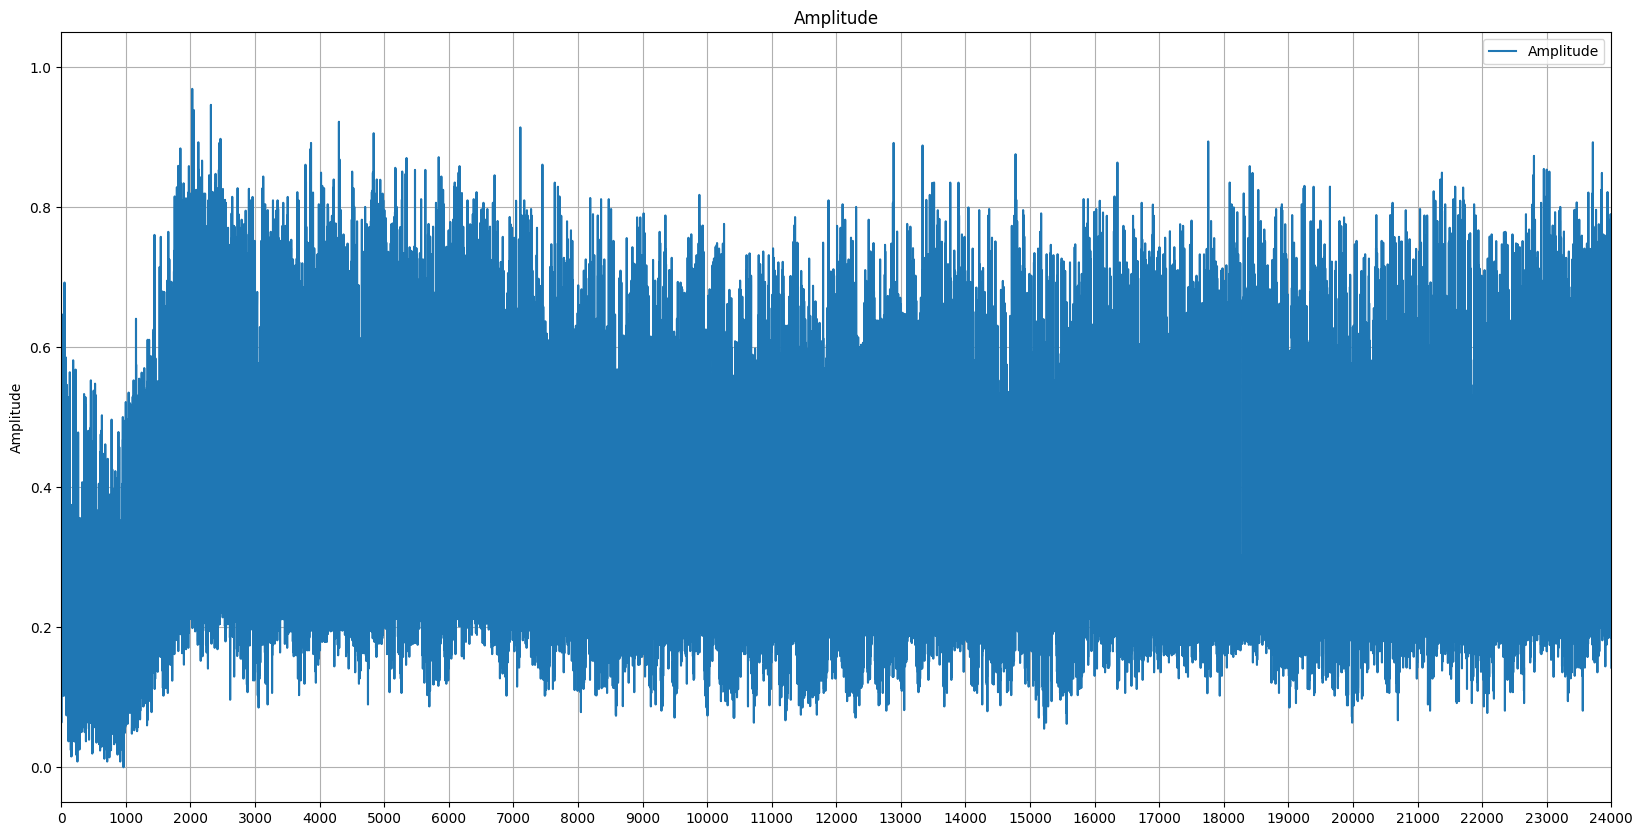

In [19]:
plot_amplitude(data=norm_drop_subcarrier_amp[5], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

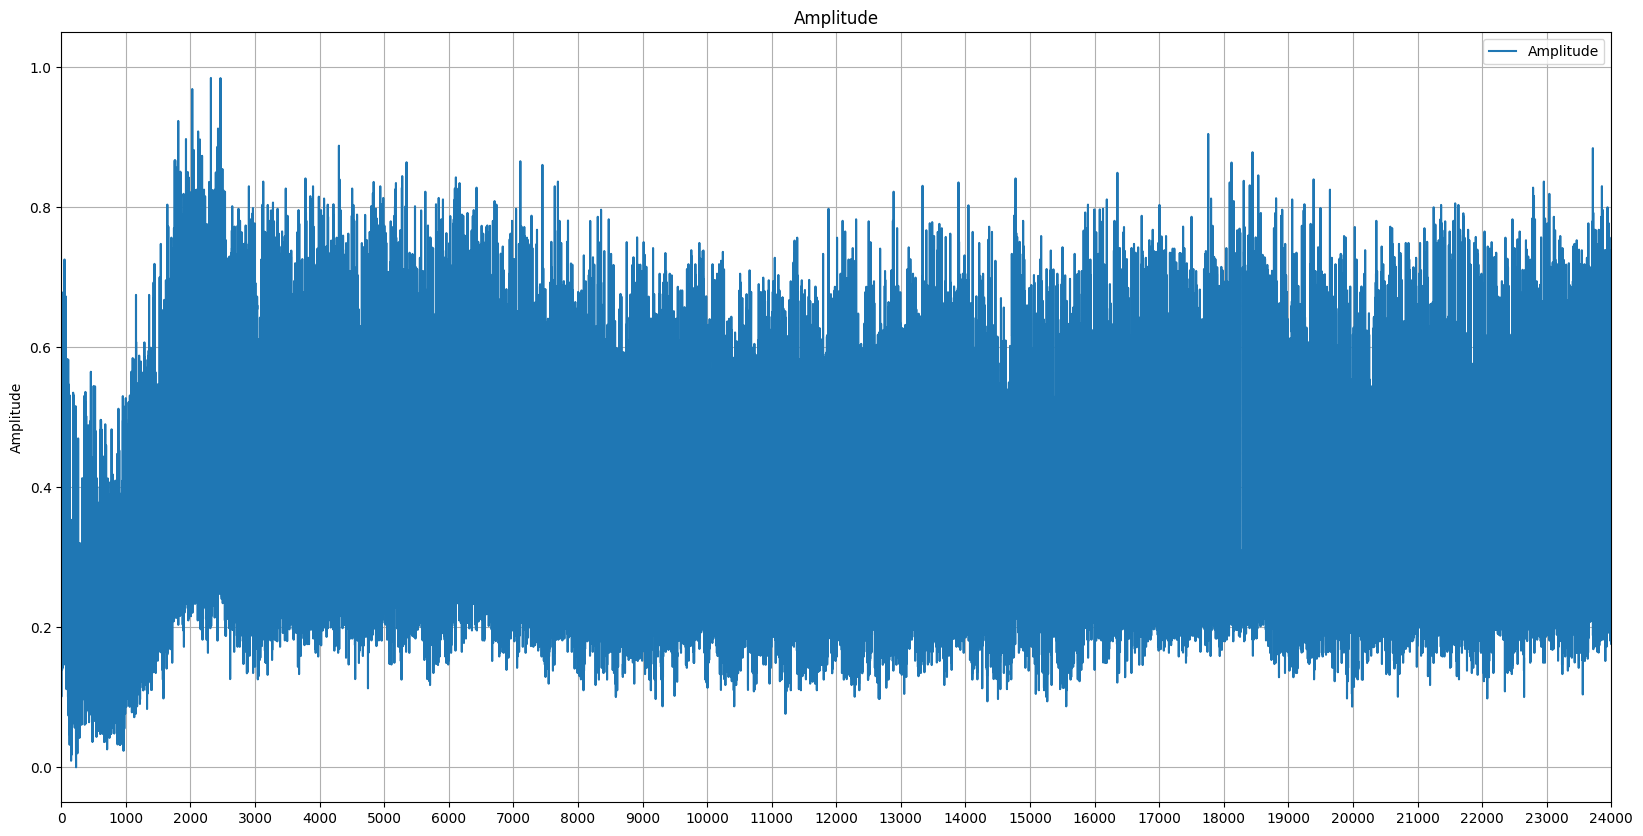

In [20]:
plot_amplitude(data=norm_drop_subcarrier_amp[10], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

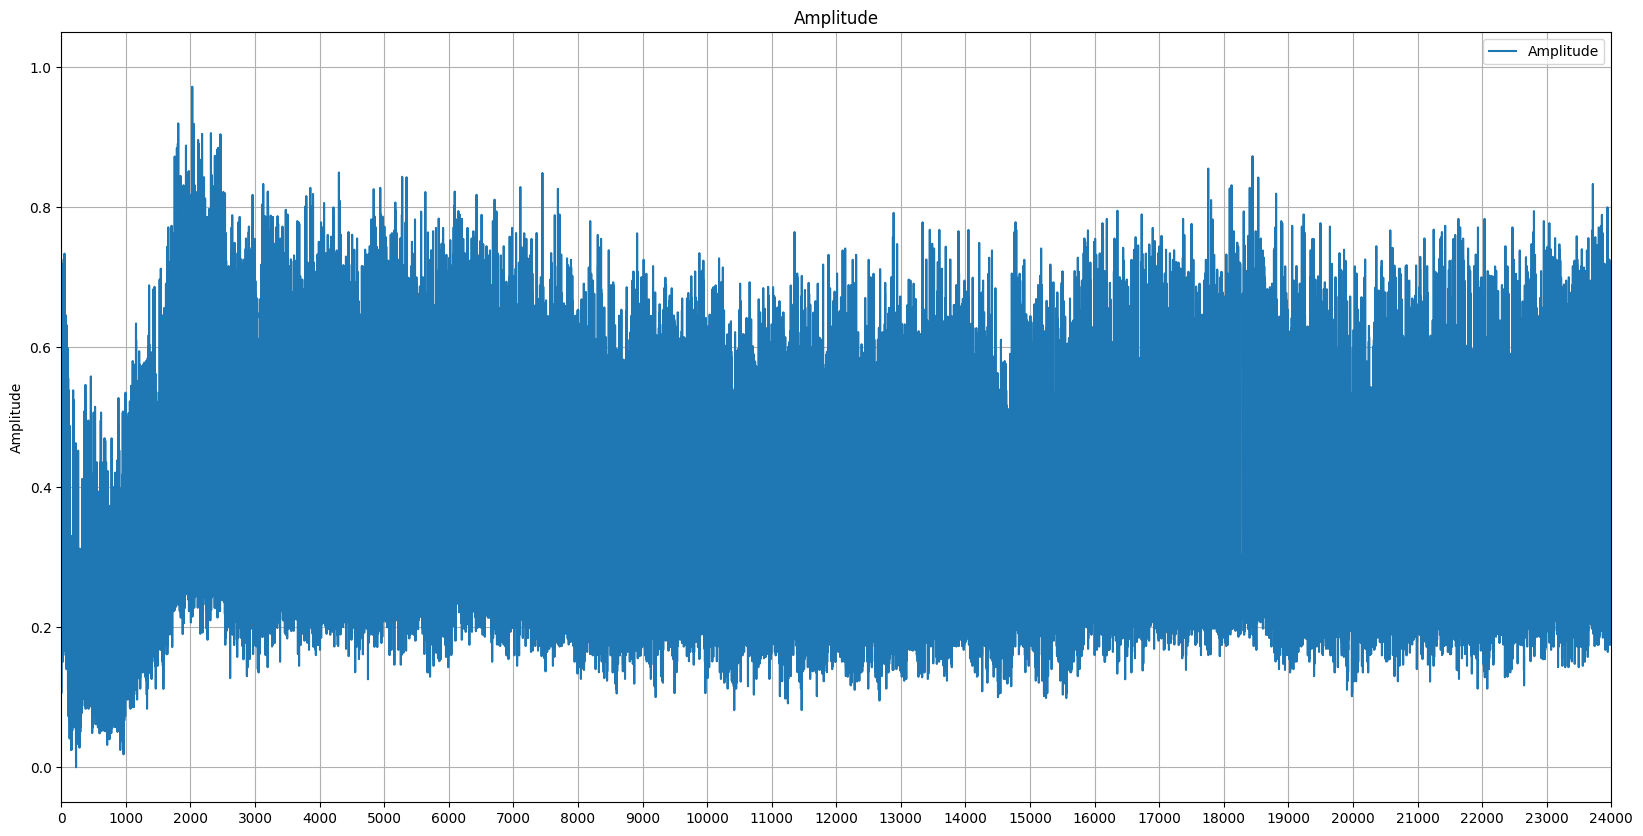

In [21]:
plot_amplitude(data=norm_drop_subcarrier_amp[15], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

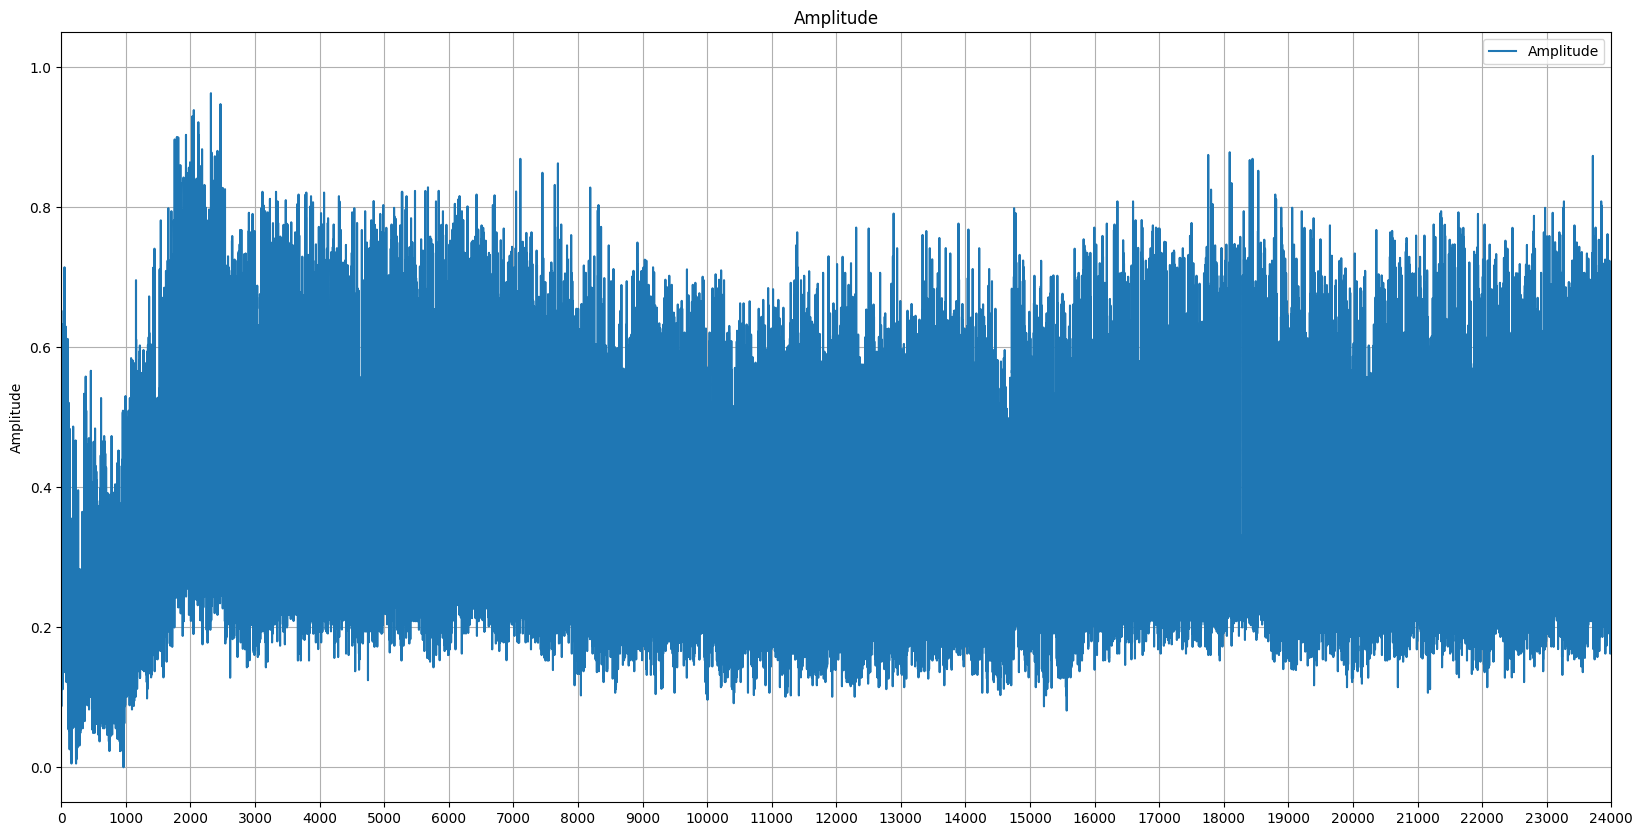

In [22]:
plot_amplitude(data=norm_drop_subcarrier_amp[20], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

In [23]:
def hampel_filter(input_matrix, window_size=None):
    input_matrix= np.asarray(input_matrix)
    n = input_matrix.shape[1]
    new_matrix = np.zeros_like(input_matrix)
    k = 1.4826  # scale factor for Gaussian distribution
    n_sigmas=1
    length = len(input_matrix)
    length = int(length/2)
    if window_size is None:
        window_size=length # change the value here
    mean_deviations = [np.zeros(input_matrix.shape[0]) for i in range(n)]
    for ti in range(n):
        start_time = max(0, ti - window_size)
        end_time = min(n, ti + window_size)
        x0 = np.nanmedian(input_matrix[:, start_time:end_time], axis=1, keepdims=True)
        s0 = k * np.nanmedian(np.abs(input_matrix[:, start_time:end_time] - x0), axis=1)
        mask = (np.abs(input_matrix[:, ti] - x0[:, 0]) > n_sigmas * s0)
        new_matrix[:, ti] = mask*x0[:, 0] + (1 - mask)*input_matrix[:, ti]
    new_matrix = pd.DataFrame(new_matrix)
    return new_matrix

In [24]:
# call Here
new_matrix = hampel_filter(norm_drop_subcarrier_amp, 13)

<Figure size 640x480 with 0 Axes>

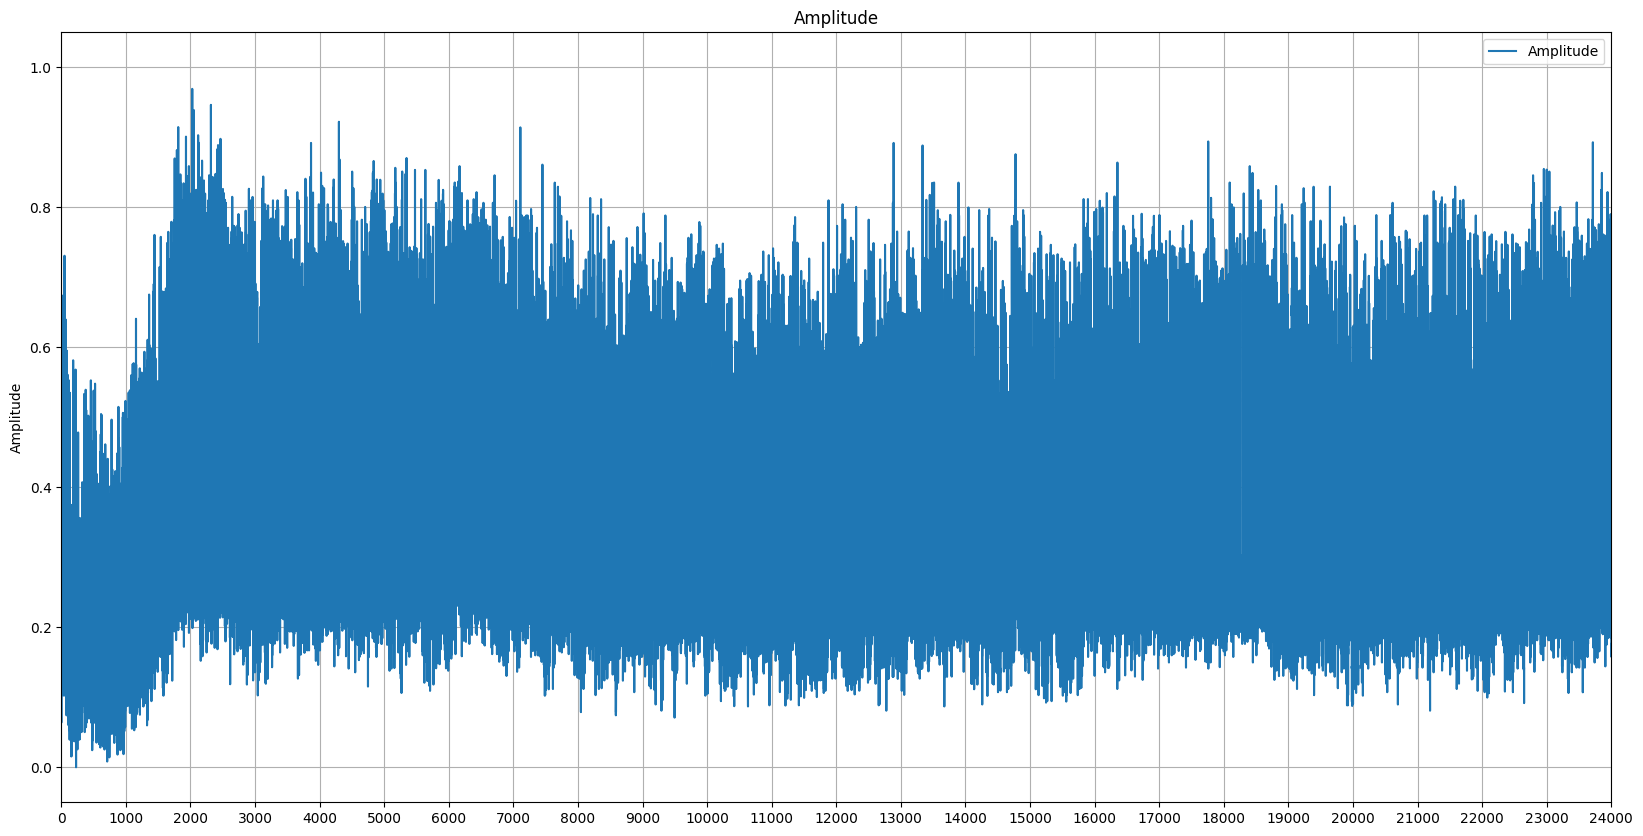

In [25]:
plot_amplitude(data=new_matrix[5], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

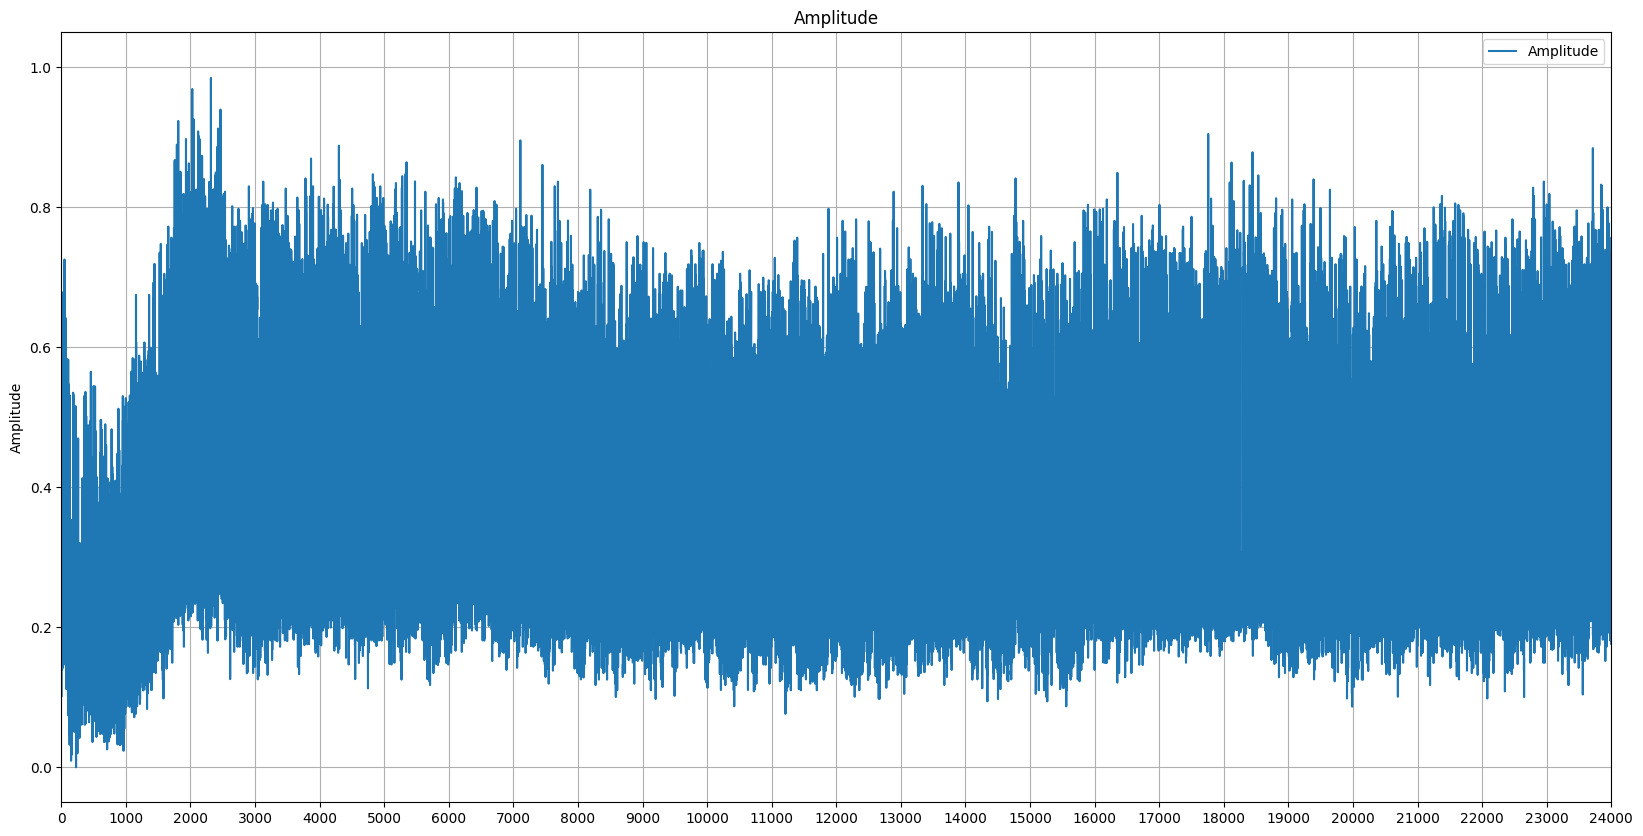

In [26]:
plot_amplitude(data=new_matrix[10], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

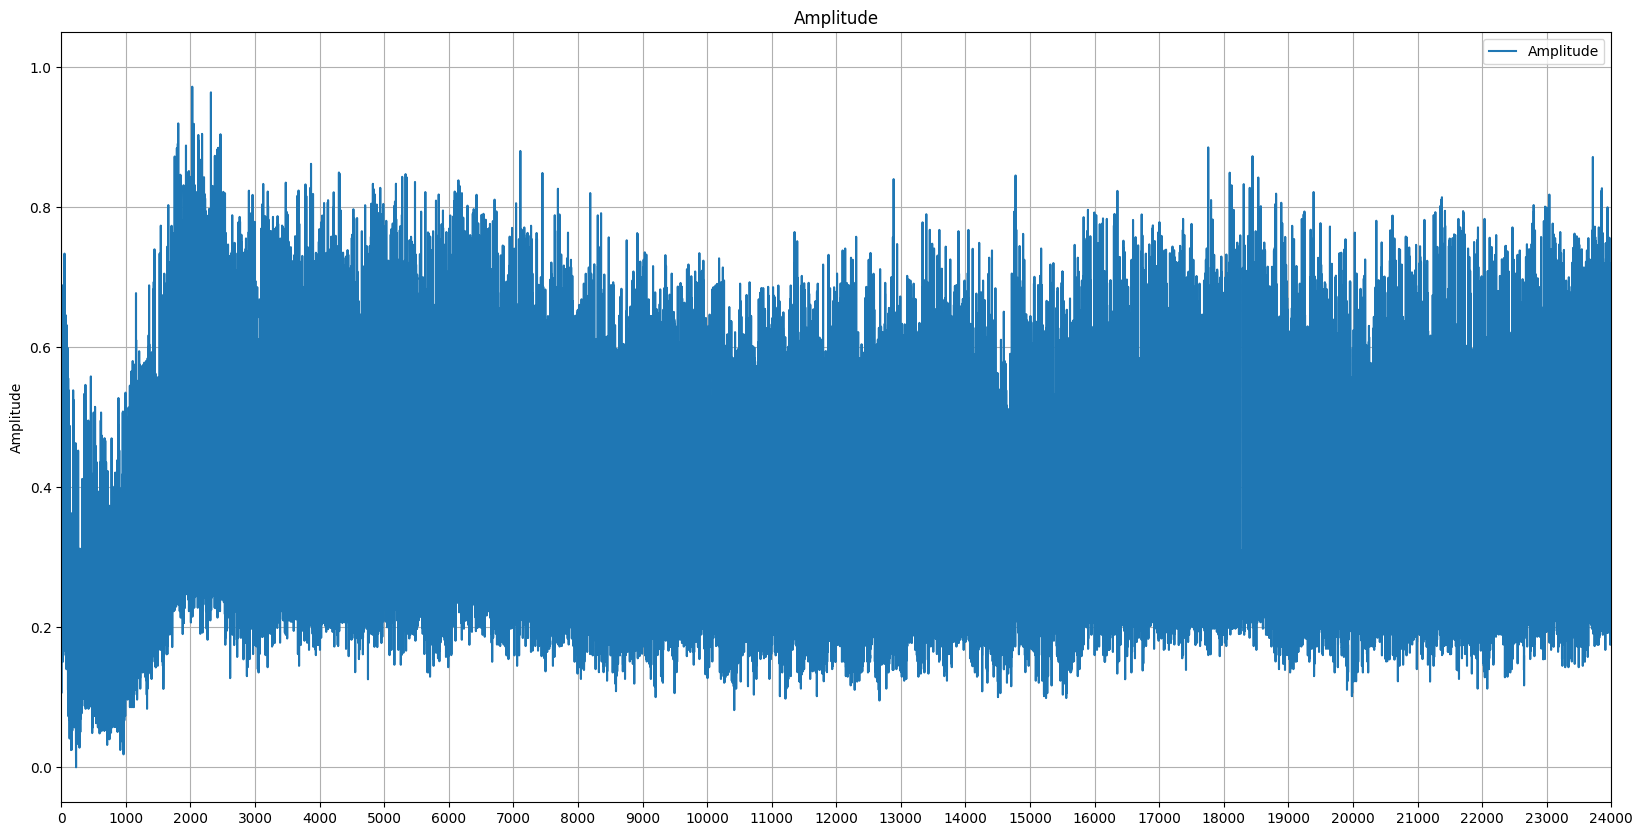

In [27]:
plot_amplitude(data=new_matrix[15], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

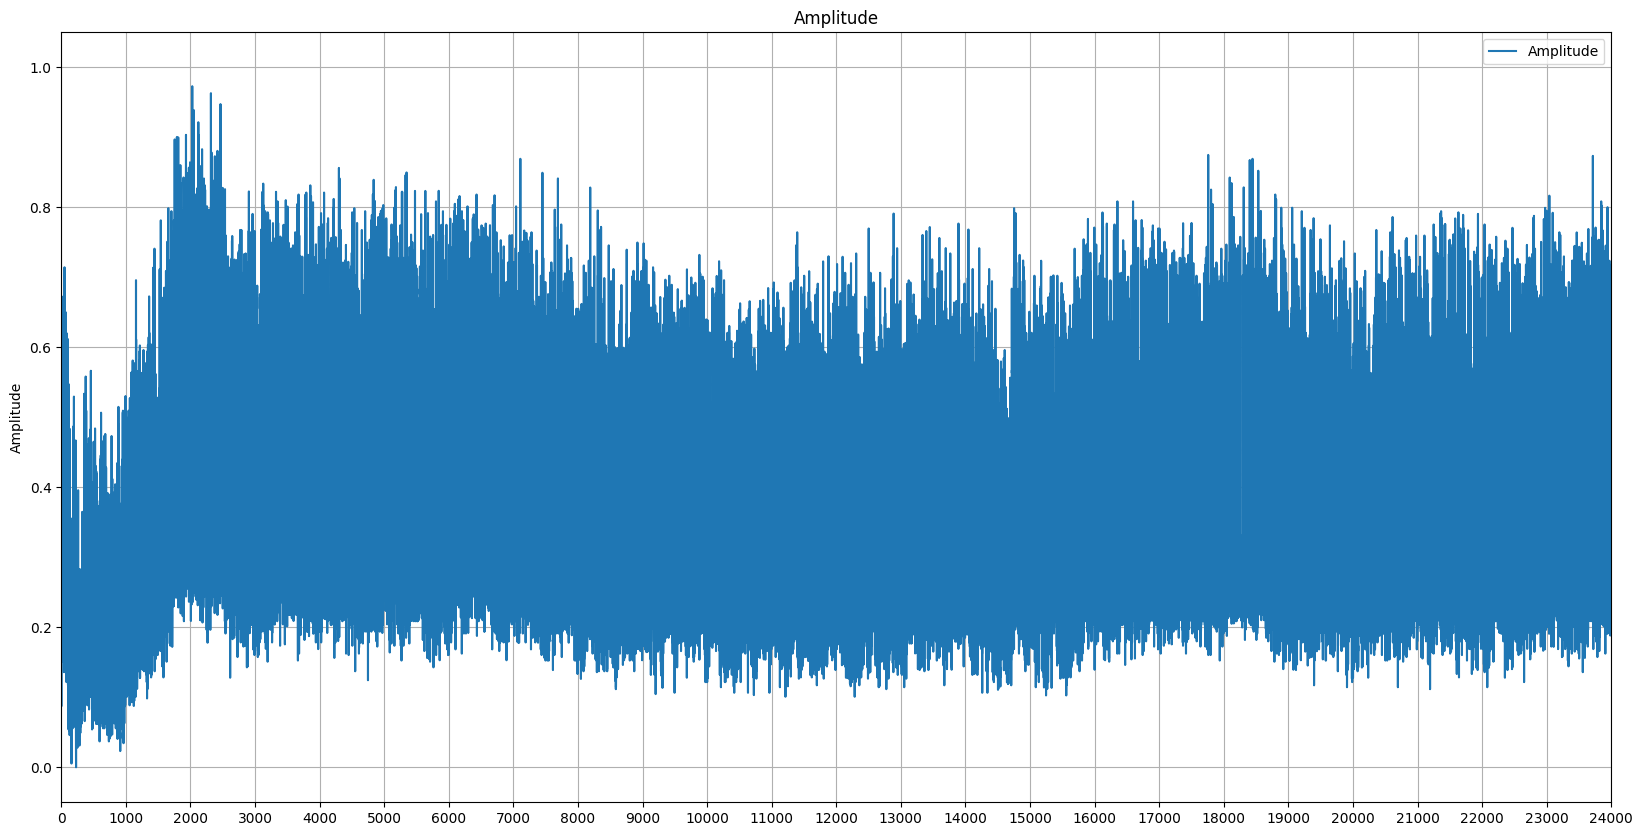

In [28]:
plot_amplitude(data=new_matrix[20], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

In [29]:
def denoise(df):
    dwt = pd.DataFrame()
    for i in range(len(df.iloc[0])):
        signal = df[i]
        coeff = pywt.wavedec(signal, wavelet='db4', mode="per")
        #coeff
        d = np.mean(np.absolute(coeff[-1] - np.mean(coeff[-1], axis=None)), axis=None)
        sigma = (1/0.6475) * d
        #sigma
        uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
        #uthresh
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
        filter = pywt.waverec(coeff, wavelet='db4', mode='per')
        #filter1 = pd.DataFrame(filter)
        dwt[i]= filter
    dwt = dwt[:-1]
    print("denoise completed")
    return dwt

In [30]:
# Call Here
dwt = denoise(new_matrix)

denoise completed


<Figure size 640x480 with 0 Axes>

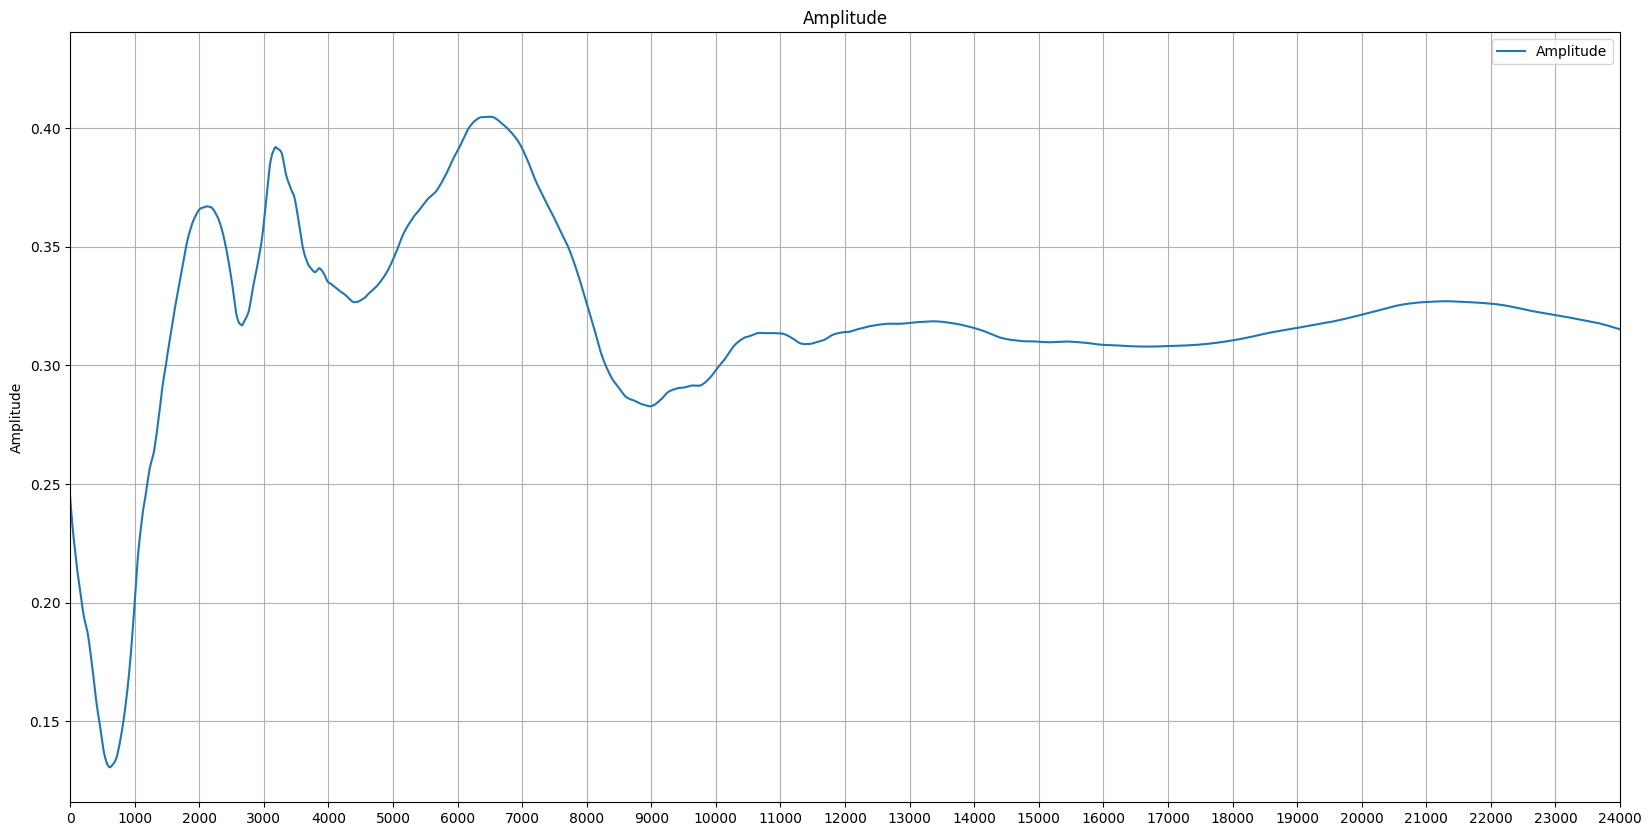

In [31]:
plot_amplitude(data=dwt[5], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

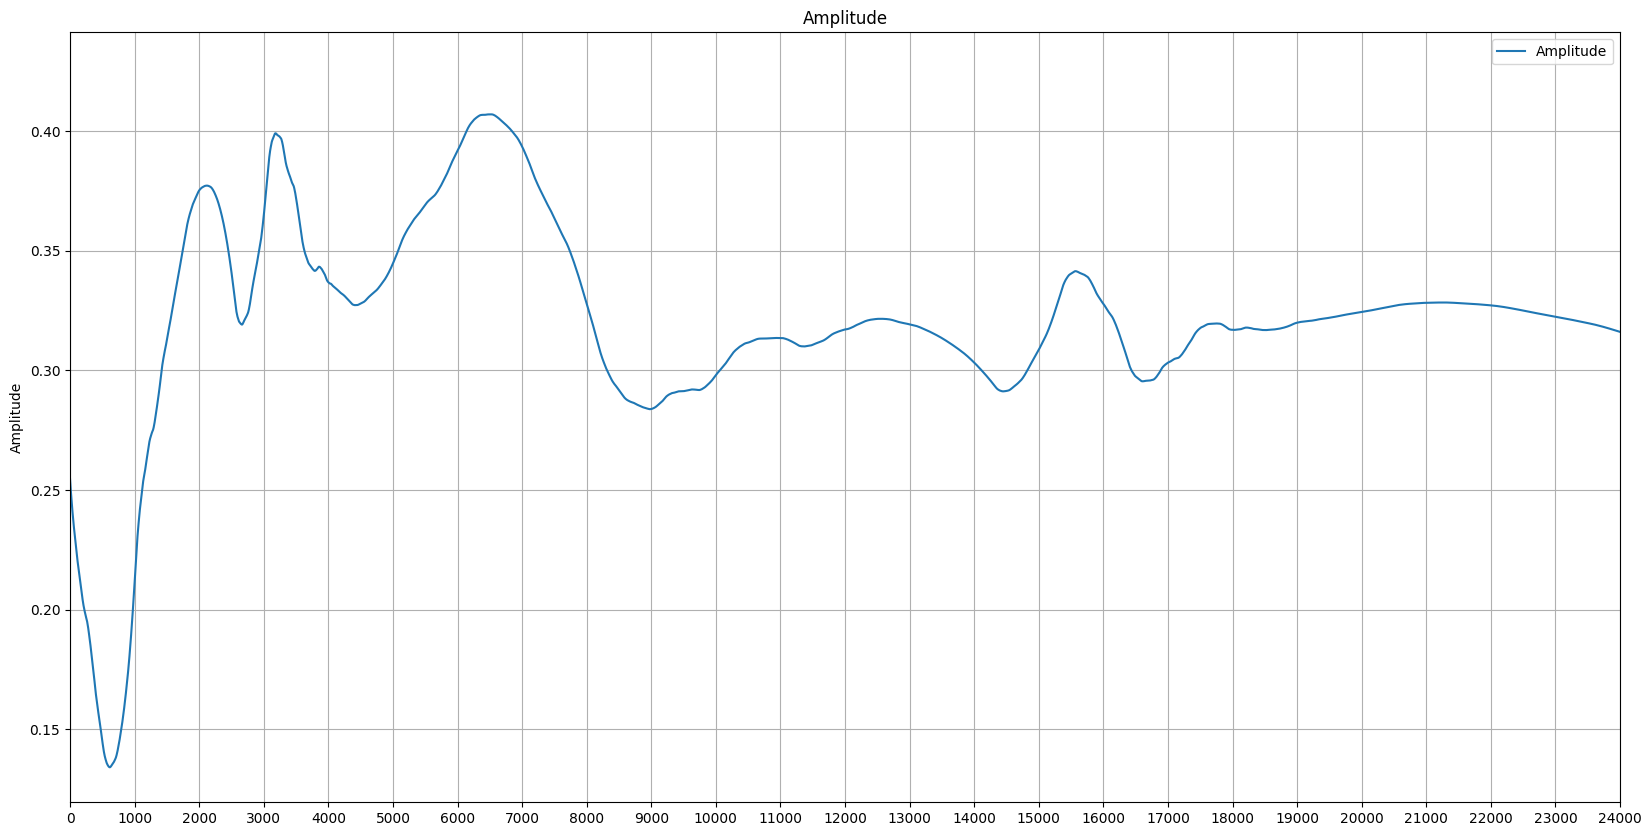

In [32]:
plot_amplitude(data=dwt[10], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

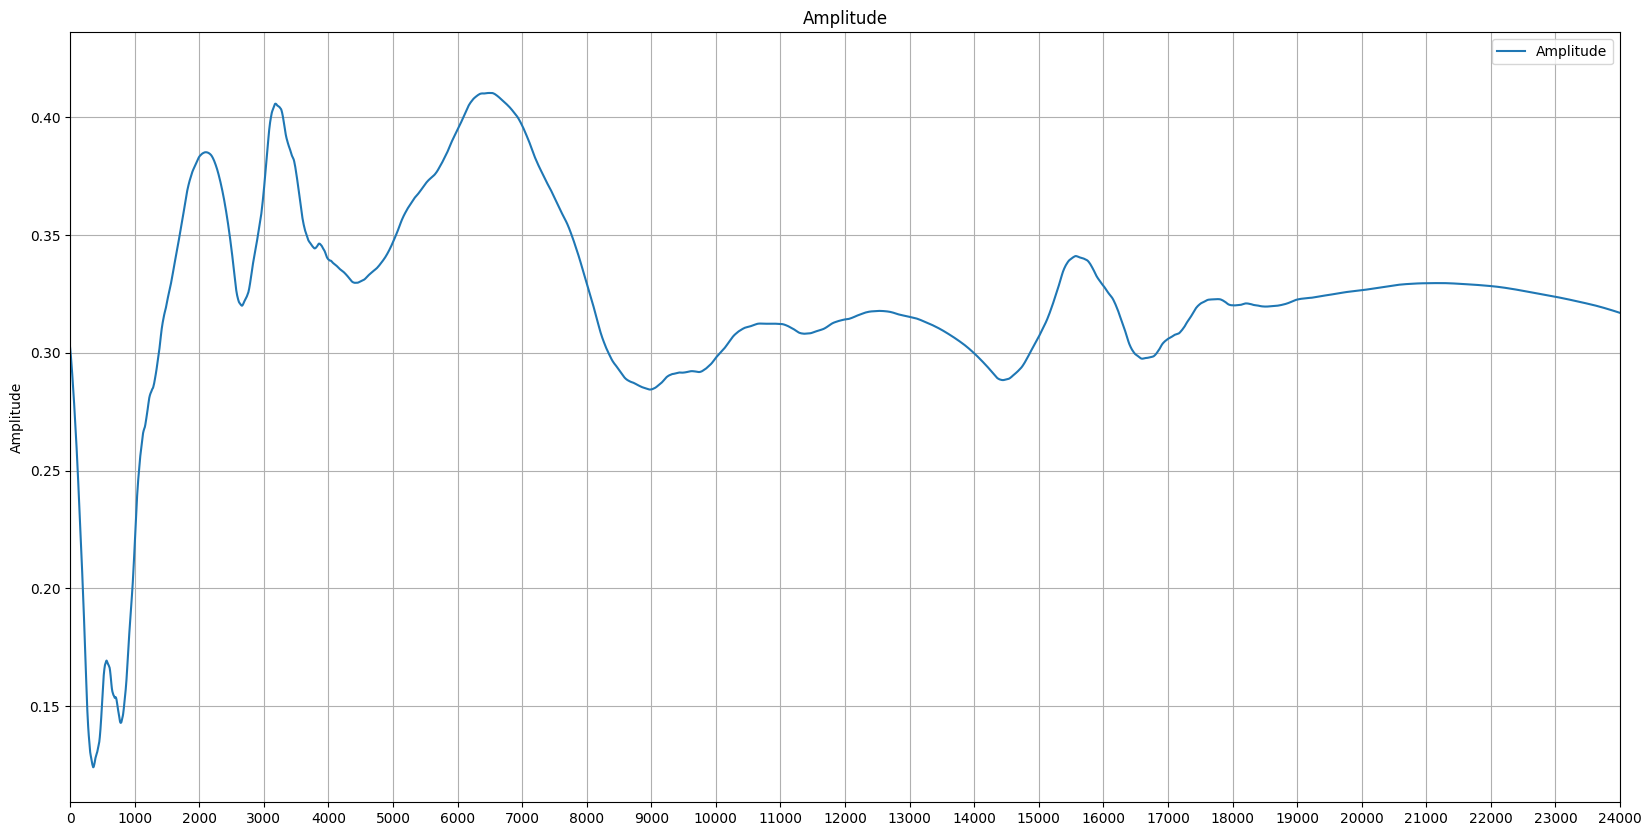

In [33]:
plot_amplitude(data=dwt[15], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

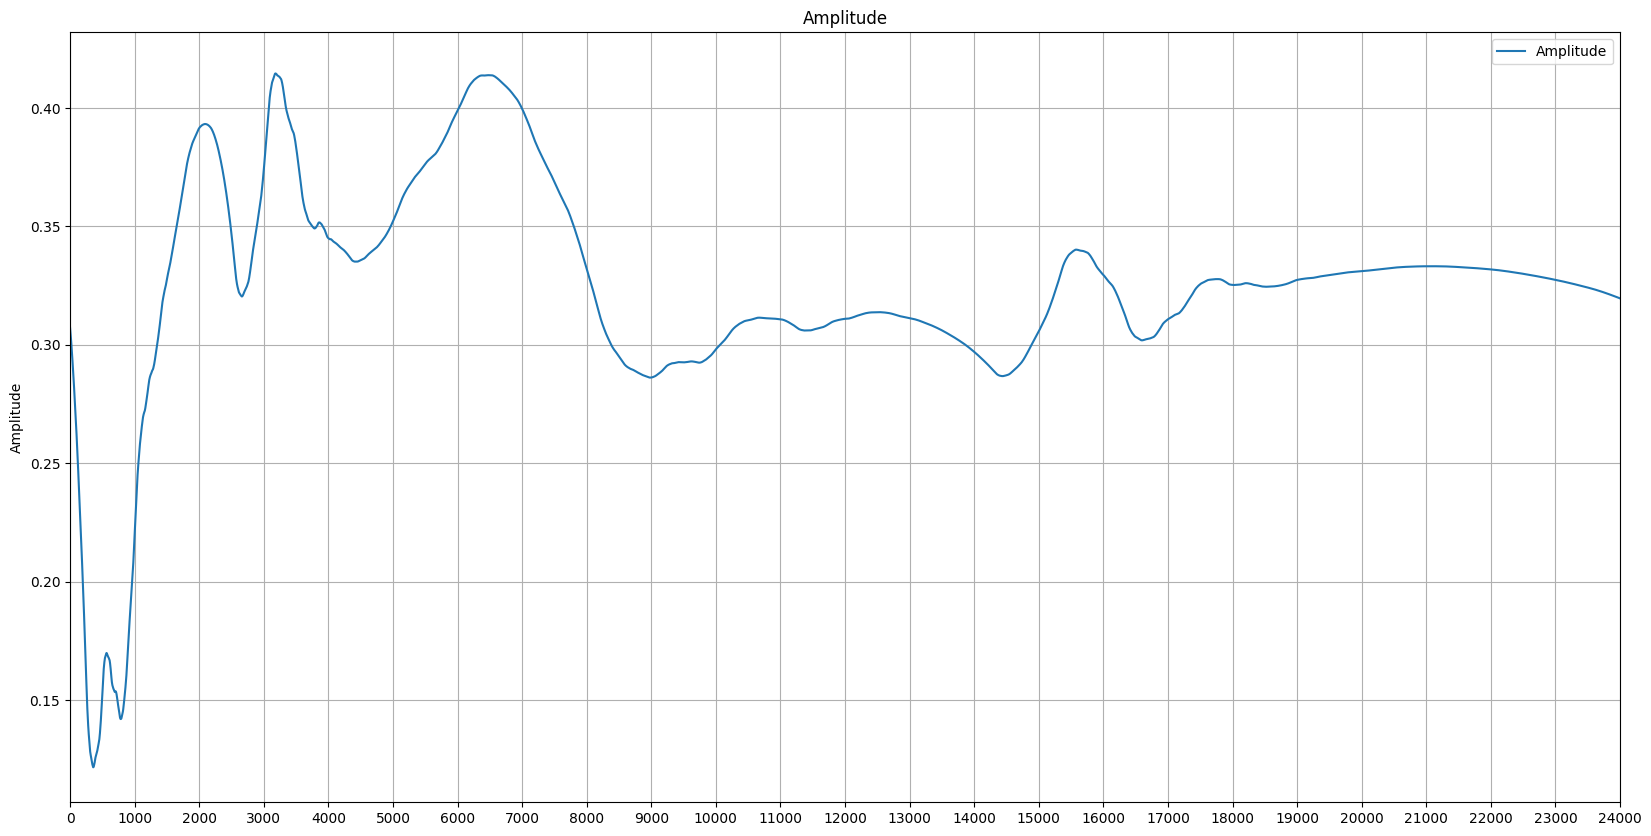

In [34]:
plot_amplitude(data=dwt[20], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

In [35]:
# convert timestamp into minute and seconds
def convert_time(data):
    from datetime import datetime
    d = data.copy()
    #df = d["timestamp"]
    time = pd.DataFrame(d)
    for i in range(0, len(time)):
        dt_obj = datetime.fromtimestamp(int(time[0][i]))
        temp = "%s.%s" % (str(dt_obj.minute).zfill(2),str(dt_obj.second).zfill(2))
        time.loc[i] = float(temp)
        #time.loc[i] = temp
    print("convert time completed")
    return time

In [36]:
# Call here
time_post_convert_time = convert_time(time)

convert time completed


In [37]:
 # apply savgol fiter
def savgol(df,train_time ):
    rd_data = []

    N_sample = len(df[0])
    print(N_sample)
    time1 = np.array(train_time)
    time1 = np.unique(time1)
    print(time1.shape[0])
    sam_rate = N_sample+1/time1.shape[0]
    print(sam_rate)
    for i in range(0, len(df.loc[0])):
        rd_ph1 = signal.savgol_filter(df[i], 51,5)
        sos = signal.butter(10,20,'low', fs=2*sam_rate, output='sos')
        rd_ph1 = signal.sosfiltfilt(sos,rd_ph1)
        rd_data.append(rd_ph1)
    smooth = pd.DataFrame(rd_data)
    smooth = smooth.transpose()
    print("savgol filter completed")
    return smooth

In [38]:
# Call Here
smooth = savgol(dwt, time_post_convert_time)

41595
846
41595.0011820331
savgol filter completed


In [39]:
df_smooth = pd.DataFrame(smooth)

<Figure size 640x480 with 0 Axes>

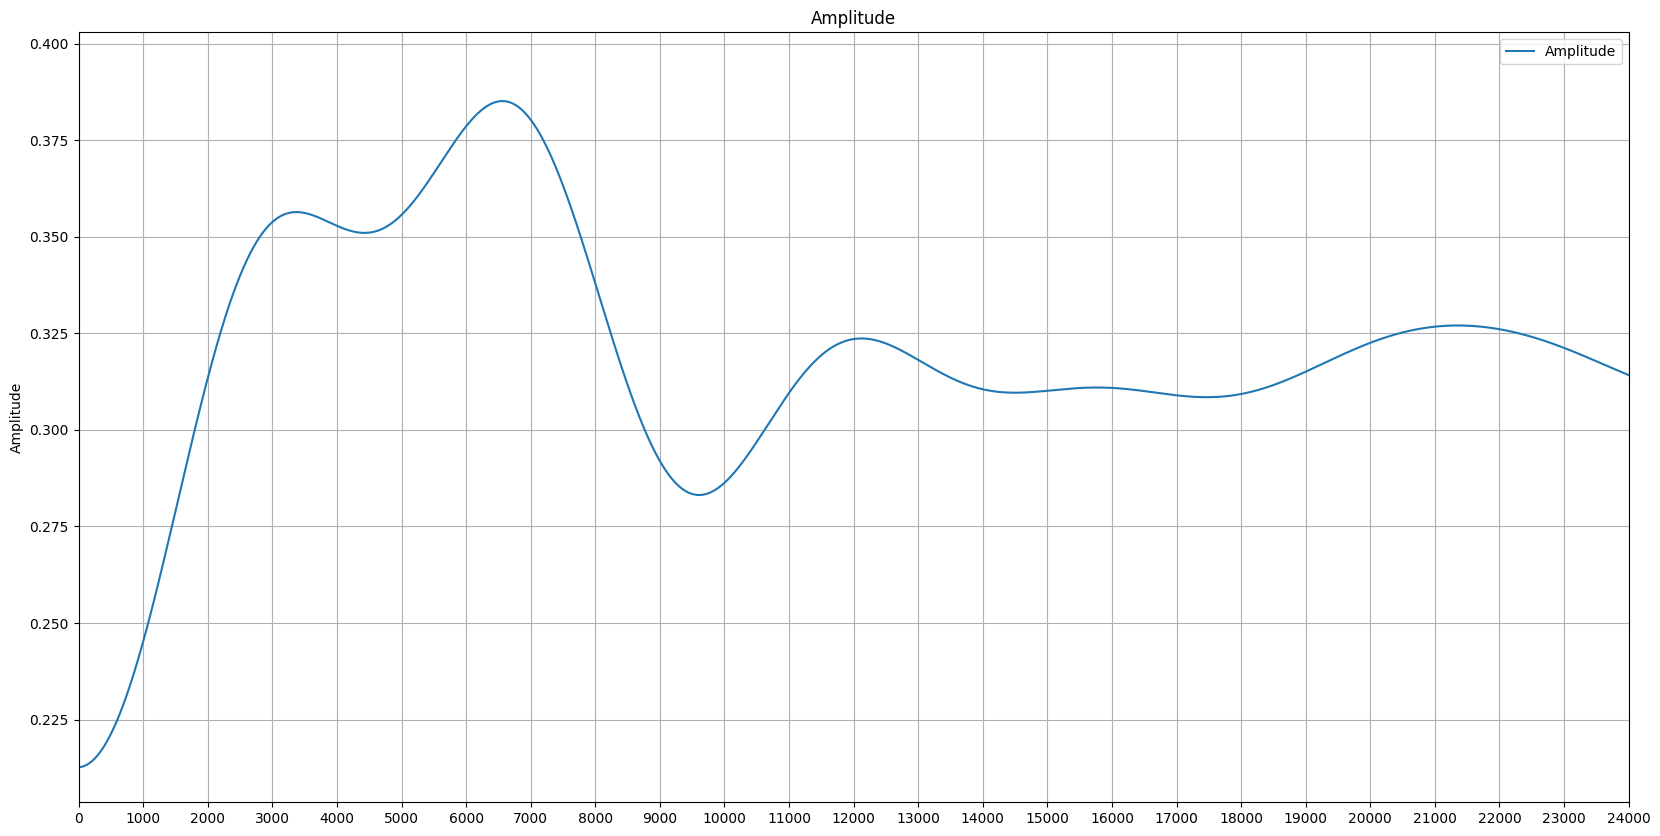

In [40]:
plot_amplitude(data=df_smooth[5], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

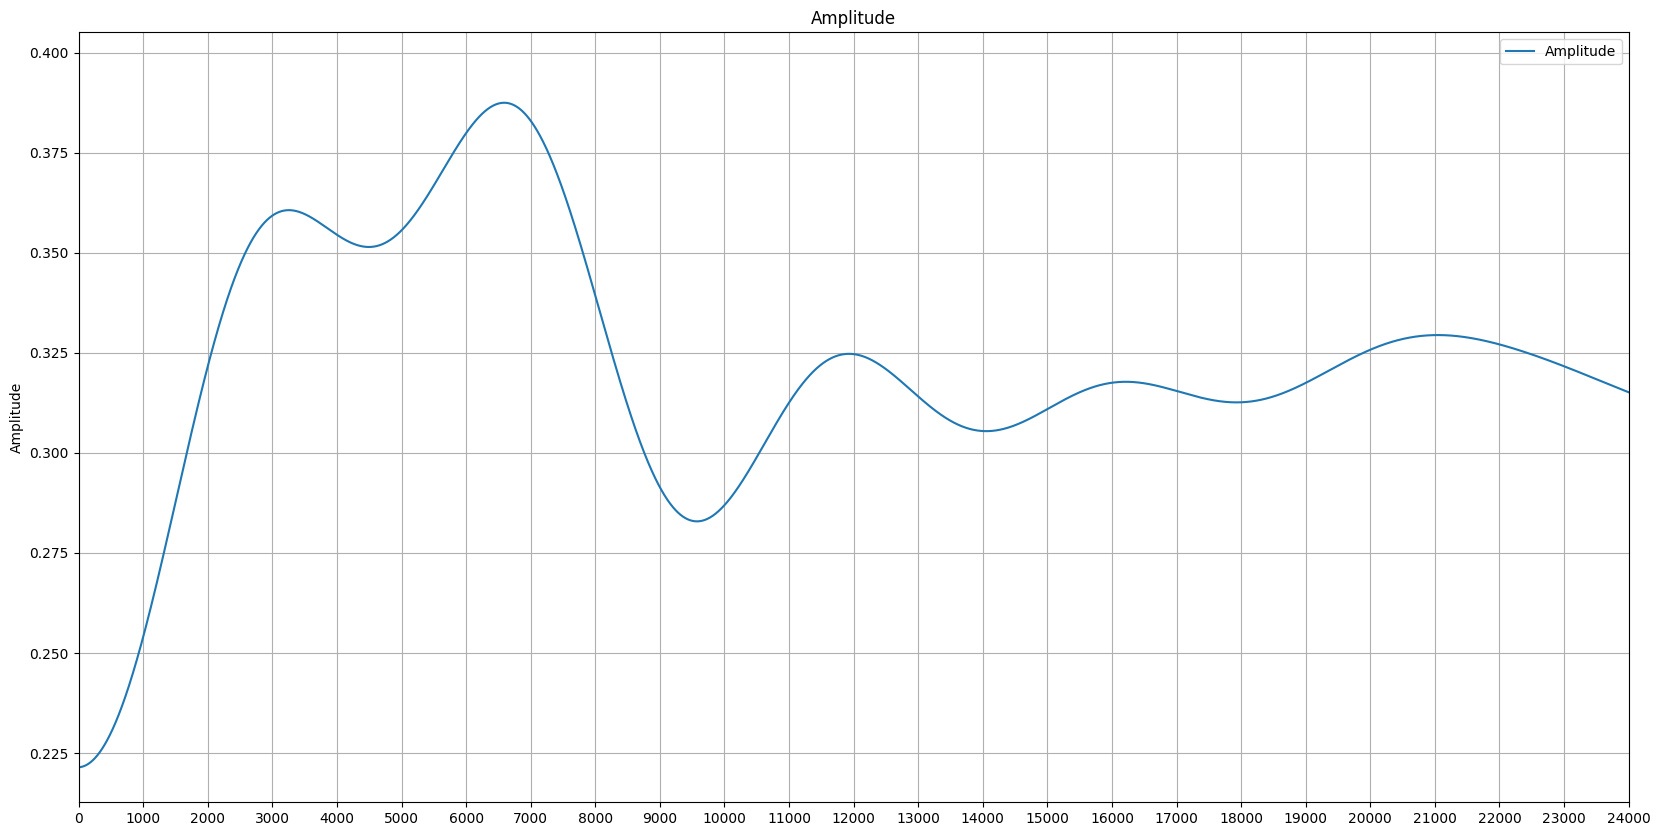

In [41]:
plot_amplitude(data=df_smooth[10], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

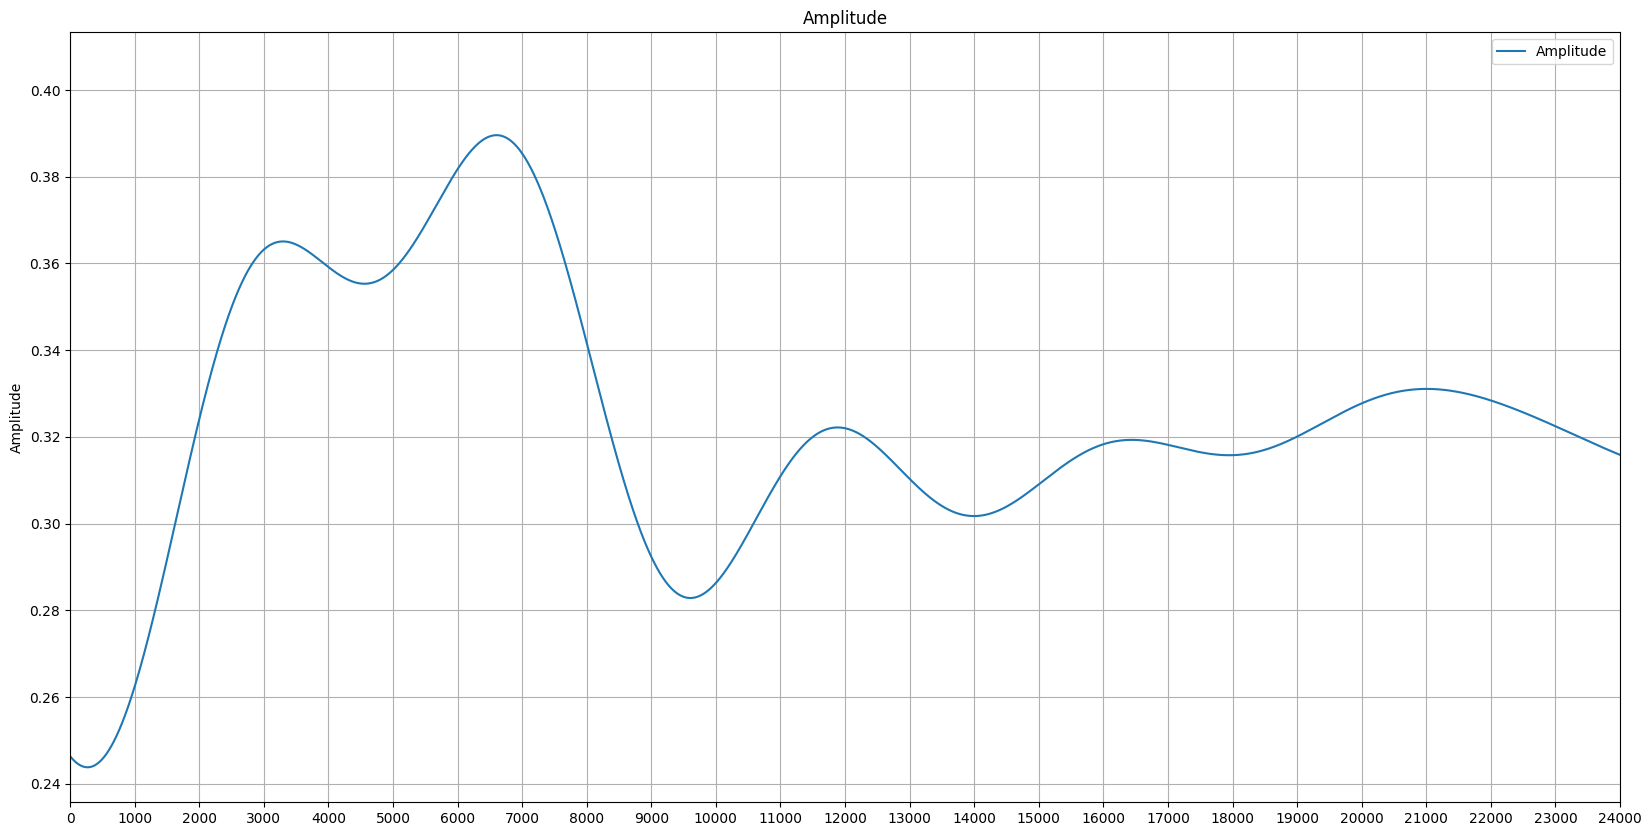

In [42]:
plot_amplitude(data=df_smooth[15], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

<Figure size 640x480 with 0 Axes>

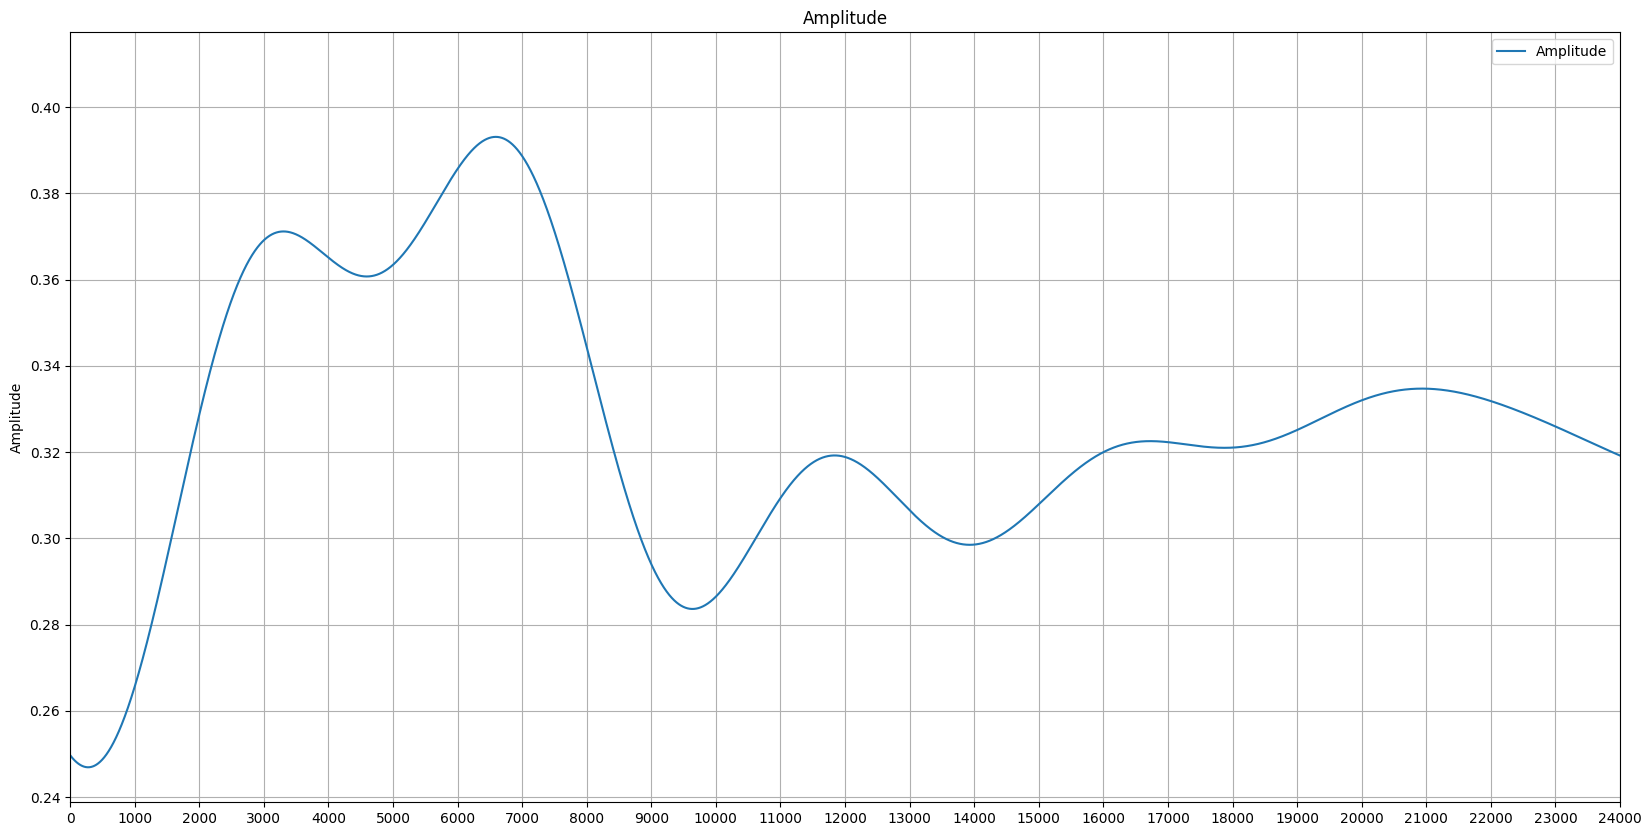

In [43]:
plot_amplitude(data=df_smooth[20], title="Amplitude", xlabel="Amplitude", xlim=(0, 1), xticks=(0, 25000, 1000))

In [44]:
def find_best(df, col):
    from sklearn.feature_selection import GenericUnivariateSelect, f_regression
    X = np.array(df)
    y = np.array(df[col])
    transformer = GenericUnivariateSelect(f_regression, mode='k_best', param=100)
    X_new = transformer.fit_transform(X, y)
    return X_new

# Call Here
X_new = find_best(smooth, 10)

In [45]:
# Make input shape as:
# First reduce the column dimension to 100
# Then make reshape to 10 X 10.

X_new = X_new.reshape(-1,10,10)
print(X_new.shape)

(41595, 10, 10)


In [46]:
# defining Attention layer.
class AttenLayer(tf.keras.layers.Layer):

    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.num_state = num_state

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature

    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state,})
        return config

In [47]:
# defining Bi-lstm with Attention Layer model
class CSIModelConfig:
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        pass

    def build_model(self, n_unit_lstm=200, n_unit_atten=400):
        """
        Returns the Tensorflow Model which uses AttenLayer
        """
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 10))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 10))
        x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_unit_lstm, return_sequences=True))(x_in)
        x_tensor = AttenLayer(n_unit_atten)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model


    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model

In [48]:
#loading pretrained model
model = tf.keras.models.load_model('/content/drive/MyDrive/WN_A4/best_atten_400nodes.hdf5',custom_objects={'AttenLayer':AttenLayer})
# input shape reuired by the model is 10 X 10.

In [49]:
# predict here
y_pred= model.predict(X_new)
t1= np.argmax(y_pred, axis=1)
t1 = pd.DataFrame(t1)
t1.columns=['headlabel']
t1.headlabel.replace((0, 1,2, 3,4,5,6),('Forward', 'Looking Up', 'Nodding', 'Looking Down', 'Shaking','Looking Left', 'Looking Right'), inplace=True)

1300/1300 [==============================] - 58s 44ms/step


In [50]:

# Engagement score calculations
def calc_score(seq):
        score=0
        for i in seq:
            if(i==1 or i==2 or i==3):
                score+=1
            elif(i==6 or i==7 or i==5):
                score-=1
            elif(i==4):
                score+=0.8
            elif(i==8):
                score-=1
            # else:
            #     score+=0.5
        return score/len(seq)
def engagement_score(time, t1):
    time = time.copy()
    headlabel_rank={'Forward':1, 'Nodding':2, 'Shaking':3, 'Looking Down':4, 'Looking Up':5, 'Looking Left':6, 'Looking Right':7, 'Unknown Gesture':8}
    time.columns= ['timestamp']
    end_time=time['timestamp'][time.shape[0]-1]
    start_time=time['timestamp'][0]
    total_time=end_time-start_time
    windows=total_time/10
    windows=math.floor(windows)

    window_size=(time.shape[0]+1)/windows
    window_size=math.floor(window_size)
    headlabels=[]

    for label in t1['headlabel']:
        headlabels.append(headlabel_rank[label])
    Windows=[]
    index=0
    for i in range(windows):
        Window=[]
        for j in range(window_size):
            try:
                Window.append(headlabels[index])
                index=index+1
            except:
                print("")
        Windows.append(Window)
    Windows_index=collections.deque()
    for i in range(len(Windows)):
        Windows_index.append(i)

    Clusters=[]

    while(len(Windows_index)>0):

        Cluster=[]
        first_index=Windows_index.popleft()
        Window=Windows[first_index]
        Cluster.append((first_index,Window))
        indexes=[]
        for index in Windows_index:
            sm=difflib.SequenceMatcher(None,Window,Windows[index])
            if(sm.ratio()>0.70): # similarity score
                indexes.append(index)
                Cluster.append((index,Windows[index]))
        for index in indexes:
            Windows_index.remove(index)
        Clusters.append(Cluster)
    scores=[0]*windows
    for cluster in Clusters:
        temp_score=[]
        for j in cluster:
            seq_score=calc_score(j[1])
            temp_score.append(seq_score)
        #sequence=cluster[0][1]
        #score=calc_score(sequence)
        score=max(temp_score)
        for seq in cluster:
            index=seq[0]
            scores[index]=score
    thresholds=[0.55]

    model_eng=[]
    window=[]
    for threshold in thresholds:
        win=0
        engaged=[]
        print("threshold: ",threshold)
        for i in scores:
            if(i>=threshold): # threshold for enumerating engage or disengage.
                engaged.append(1)
                model_eng.append(1)
                win=win+1
                window.append(win)
            else:
                engaged.append(0)
                model_eng.append(0)
                win=win+1
                window.append(win)
    print(sum(engaged)/len(engaged))

In [51]:
# call Here
engagement_score(time, t1)

threshold:  0.55
0.8571428571428571
